In [1]:
%pprint

Pretty printing has been turned OFF


## 2016 Election Project 

This notebook is intended to document my attempts at NER annotation of my data throughout this project. The data I am starting out with are transcripts of the presidential debates from the 2016 US Election between Hillary Clinton and Donald Trump. The transcripts were taken from UCSB's American Presidency Project:

Presidential Candidates Debates: "Presidential Debate at the University of Nevada in Las Vegas," October 19, 2016. Online by Gerhard Peters and John T. Woolley, The American Presidency Project. http://www.presidency.ucsb.edu/ws/?pid=119039.

Presidential Candidates Debates: "Presidential Debate at Washington University in St. Louis, Missouri," October 9, 2016. Online by Gerhard Peters and John T. Woolley, The American Presidency Project. http://www.presidency.ucsb.edu/ws/?pid=119038.

Presidential Candidates Debates: "Presidential Debate at Hofstra University in Hempstead, New York," September 26, 2016. Online by Gerhard Peters and John T. Woolley, The American Presidency Project. http://www.presidency.ucsb.edu/ws/?pid=118971.

I will eventually use the primary debate transcripts as well.

In [2]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import pandas as pd
import glob
import os
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
os.chdir('/Users/Paige/Documents/Data_Science/2016-Election-Project/data/Debates/general')
files = glob.glob("*.txt")
files

['10-19-16.txt', '10-9-16.txt', '9-26-16.txt']

In [4]:
#I'm creating a list where each entry in the list is a transcript
transcripts = []
for f in files:
    fi = open(f, 'r')
    txt = fi.read()
    fi.close
    transcripts.append(txt)

In [5]:
print(transcripts[0][:200])

PARTICIPANTS:
Former Secretary of State Hillary Clinton (D) and
Businessman Donald Trump (R)
MODERATOR:
Chris Wallace (Fox News)

WALLACE: Good evening from the Thomas and Mack Center at the Universit


**Let's start out with one transcript and see what we can get working. I plan on trying NLTK's nltk.ne_chunk_sents() to do annotation. I don't know how well it will work for conversational data in this format, but I'll try it out because it's a simple place to start.**

In [6]:
debate1 = transcripts[2]
print(debate1[:500])

PARTICIPANTS:
Former Secretary of State Hillary Clinton (D) and
Businessman Donald Trump (R)
MODERATOR:
Lester Holt (NBC News)

HOLT: Good evening from Hofstra University in Hempstead, New York. I'm Lester Holt, anchor of "NBC Nightly News." I want to welcome you to the first presidential debate.

The participants tonight are Donald Trump and Hillary Clinton. This debate is sponsored by the Commission on Presidential Debates, a nonpartisan, nonprofit organization. The commission drafted tonight'


In [7]:
#Sentence tokenization
d1sents = nltk.sent_tokenize(debate1)
d1sents[:6]
#For now, I'm not going to touch that top bit with the debate information and see what happens. It will most likely need cleaning up

['PARTICIPANTS:\nFormer Secretary of State Hillary Clinton (D) and\nBusinessman Donald Trump (R)\nMODERATOR:\nLester Holt (NBC News)\n\nHOLT: Good evening from Hofstra University in Hempstead, New York.', 'I\'m Lester Holt, anchor of "NBC Nightly News."', 'I want to welcome you to the first presidential debate.', 'The participants tonight are Donald Trump and Hillary Clinton.', 'This debate is sponsored by the Commission on Presidential Debates, a nonpartisan, nonprofit organization.', "The commission drafted tonight's format, and the rules have been agreed to by the campaigns."]

In [8]:
d1sents[25]

'Beginning with you, Secretary Clinton, why are you a better choice than your opponent to create the kinds of jobs that will put more money into the pockets of American works?'

In [9]:
#Word tokenization in each sentence
d1toks_sents = [nltk.word_tokenize(sent) for sent in d1sents]
d1toks_sents[0:3]

[['PARTICIPANTS', ':', 'Former', 'Secretary', 'of', 'State', 'Hillary', 'Clinton', '(', 'D', ')', 'and', 'Businessman', 'Donald', 'Trump', '(', 'R', ')', 'MODERATOR', ':', 'Lester', 'Holt', '(', 'NBC', 'News', ')', 'HOLT', ':', 'Good', 'evening', 'from', 'Hofstra', 'University', 'in', 'Hempstead', ',', 'New', 'York', '.'], ['I', "'m", 'Lester', 'Holt', ',', 'anchor', 'of', '``', 'NBC', 'Nightly', 'News', '.', "''"], ['I', 'want', 'to', 'welcome', 'you', 'to', 'the', 'first', 'presidential', 'debate', '.']]

In [10]:
#POS tagging for each sentence
d1pos_sents = [nltk.pos_tag(sent) for sent in d1toks_sents]
d1pos_sents[0]

[('PARTICIPANTS', 'NNS'), (':', ':'), ('Former', 'NNP'), ('Secretary', 'NNP'), ('of', 'IN'), ('State', 'NNP'), ('Hillary', 'NNP'), ('Clinton', 'NNP'), ('(', '('), ('D', 'NNP'), (')', ')'), ('and', 'CC'), ('Businessman', 'NNP'), ('Donald', 'NNP'), ('Trump', 'NNP'), ('(', '('), ('R', 'NNP'), (')', ')'), ('MODERATOR', 'NN'), (':', ':'), ('Lester', 'NNP'), ('Holt', 'NNP'), ('(', '('), ('NBC', 'NNP'), ('News', 'NNP'), (')', ')'), ('HOLT', 'NN'), (':', ':'), ('Good', 'JJ'), ('evening', 'NN'), ('from', 'IN'), ('Hofstra', 'NNP'), ('University', 'NNP'), ('in', 'IN'), ('Hempstead', 'NNP'), (',', ','), ('New', 'NNP'), ('York', 'NNP'), ('.', '.')]

In [11]:
d1pos_sents[1]

[('I', 'PRP'), ("'m", 'VBP'), ('Lester', 'JJ'), ('Holt', 'NNP'), (',', ','), ('anchor', 'NN'), ('of', 'IN'), ('``', '``'), ('NBC', 'NNP'), ('Nightly', 'NNP'), ('News', 'NNP'), ('.', '.'), ("''", "''")]

In [12]:
d1pos_sents[4]

[('This', 'DT'), ('debate', 'NN'), ('is', 'VBZ'), ('sponsored', 'VBN'), ('by', 'IN'), ('the', 'DT'), ('Commission', 'NNP'), ('on', 'IN'), ('Presidential', 'NNP'), ('Debates', 'NNP'), (',', ','), ('a', 'DT'), ('nonpartisan', 'JJ'), (',', ','), ('nonprofit', 'JJ'), ('organization', 'NN'), ('.', '.')]

In [13]:
#Named Entity Chunking
d1chunked_sents = nltk.ne_chunk_sents(d1pos_sents)

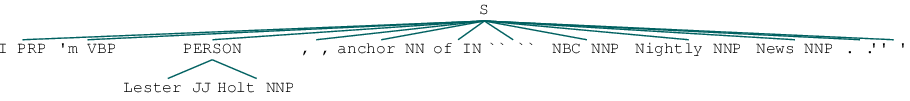

In [14]:
d1chunked_sents = list(d1chunked_sents)
d1chunked_sents[1]

In [15]:
#It didn't get all of Secretary Clinton as the PERSON...just Clinton
print(d1chunked_sents[25])

(S
  Beginning/VBG
  with/IN
  you/PRP
  ,/,
  Secretary/NNP
  (PERSON Clinton/NNP)
  ,/,
  why/WRB
  are/VBP
  you/PRP
  a/DT
  better/JJR
  choice/NN
  than/IN
  your/PRP$
  opponent/NN
  to/TO
  create/VB
  the/DT
  kinds/NNS
  of/IN
  jobs/NNS
  that/WDT
  will/MD
  put/VB
  more/JJR
  money/NN
  into/IN
  the/DT
  pockets/NNS
  of/IN
  (GPE American/NNP)
  works/NNS
  ?/.)


In [16]:
for sent in d1chunked_sents[:50]:
    for chunk in sent:
        if hasattr(chunk, "label") and chunk.label() == "NE":
            print(chunk)

**This does a nice job of pulling out the NE's, but it doesn't tell us where they're located in the text unless you look at the trees...**

In [17]:
dir(d1chunked_sents[0][0])

['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'count', 'index']

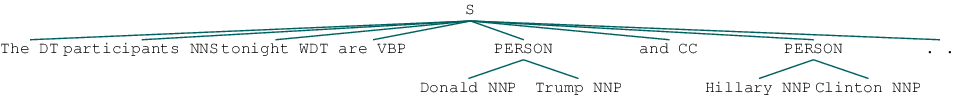

In [18]:
d1chunked_sents[3]

In [19]:
d1chunked_sents[3].set_label('HOLT')

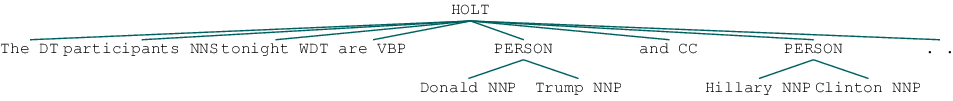

In [20]:
d1chunked_sents[3]

**It's probably not smart to get rid of S as the head label... but maybe it would be helpful to change it to the speaker? There doesn't seem to be a way for me to link the NE's either.**

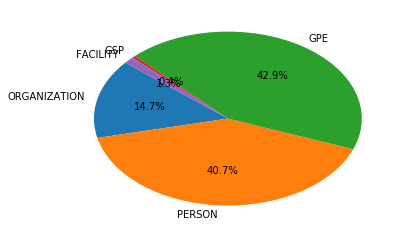

In [21]:
#This section is with help from a datacamp tutorial
#https://campus.datacamp.com/courses/natural-language-processing-fundamentals-in-python/named-entity-recognition?ex=3

ner_categories = defaultdict(int)

# Create the nested for loop
for sent in d1chunked_sents:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            ner_categories[chunk.label()] += 1
            
# Create a list from the dictionary keys for the chart labels: labels
labels = list(ner_categories.keys())

# Create a list of the values: values
values = [ner_categories.get(l) for l in labels]

# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Display the chart
plt.show()

In [22]:
people = []
for sent in d1chunked_sents:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            if chunk.label() == 'PERSON':
                people.append(chunk)

In [23]:
gpe = []
for sent in d1chunked_sents:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            if chunk.label() == 'GPE':
                gpe.append(chunk)

In [24]:
org = []
for sent in d1chunked_sents:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            if chunk.label() == 'ORGANIZATION':
                org.append(chunk)

In [25]:
facility = []
for sent in d1chunked_sents:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            if chunk.label() == 'FACILITY':
                facility.append(chunk)

In [26]:
len(people)

291

In [27]:
len(gpe)

307

In [28]:
len(org)

105

In [29]:
len(facility)

9

In [30]:
for x in facility:
    print(x)

(FACILITY Wall/NNP Street/NNP)
(FACILITY Wall/NNP Street/NNP)
(FACILITY White/NNP House/NNP)
(FACILITY Fifth/NNP Amendment/NNP)
(FACILITY Kennedy/NNP)
(FACILITY Pennsylvania/NNP Avenue/NNP)
(FACILITY White/NNP House/NNP)
(FACILITY Pennsylvania/NNP Avenue/NNP)
(FACILITY Wall/NNP Street/NNP Journal/NNP)


In [31]:
for x in org:
    print(x)

(ORGANIZATION State/NNP)
(ORGANIZATION NBC/NNP News/NNP)
(ORGANIZATION Hofstra/NNP University/NNP)
(ORGANIZATION Commission/NNP)
(ORGANIZATION Democratic/JJ)
(ORGANIZATION Republican/NNP)
(ORGANIZATION Carrier/NNP)
(ORGANIZATION VAT/NNP)
(ORGANIZATION NAFTA/NNP)
(ORGANIZATION Great/NNP Recession/NNP)
(ORGANIZATION OK/NNP)
(ORGANIZATION Obama/NNP)
(ORGANIZATION Michigan/NNP)
(ORGANIZATION Ohio/NNP)
(ORGANIZATION NAFTA/NNP)
(ORGANIZATION NAFTA/NNP)
(ORGANIZATION Senate/NNP)
(ORGANIZATION CAFTA/NNP)
(ORGANIZATION NAFTA/NNP)
(ORGANIZATION NAFTA/NNP)
(ORGANIZATION NAFTA/NNP)
(ORGANIZATION ISIS/NNP)
(ORGANIZATION ISIS/NNP)
(ORGANIZATION General/NNP Douglas/NNP)
(ORGANIZATION MacArthur/NNP)
(ORGANIZATION ISIS/NNP)
(ORGANIZATION ISIS/NNP)
(ORGANIZATION Democrats/NNPS)
(ORGANIZATION Trump/NNP)
(ORGANIZATION Great/NNP Depression/NNP)
(ORGANIZATION Fed/NNP)
(ORGANIZATION Fed/NNP)
(ORGANIZATION Fed/NNP)
(ORGANIZATION Fed/NNP)
(ORGANIZATION IRS/NNP)
(ORGANIZATION IRS/NNP)
(ORGANIZATION IRS/NNP)
(OR

In [32]:
people[1].leaves()[0][0]
words = [leaf[0] for leaf in people[1].leaves()]
words

['Businessman', 'Donald', 'Trump']

In [33]:
people_names = []
name = ''
for tree in people:
    for leaf in tree.leaves():
        name+=' '+str(leaf[0])
    people_names.append(name.strip())
    name = ''


In [34]:
set(people_names)

{'Blumenthal', 'Bernie Sanders', 'Muslims', 'Donald J. Trump', 'Sean', 'Miss Housekeeping', 'Detroit', 'Howard Stern', 'Trump', 'Putin', 'Sean Hannity', 'Lester Holt', 'Incomes', 'Neil Cavuto', 'Hillary Clinton', 'Nevada Las Vegas', 'Lester', 'George W. Bush', 'Hannity', 'Clinton', 'Miss Piggy', 'Patti Doyle', 'Charlotte', 'Alicia Machado', 'Hillary', "Rosie O'Donnell", 'Bibi Netanyahu', 'Barack Obama', 'Ronald Reagan', 'CLINTON', 'Rahami', 'Mr. Trump', 'Wolf Blitzer', 'Michigan', 'Michelle Obama', 'Fox', 'Kerry', 'Patti Solis Doyle', 'Border Patrol', 'Debbie Wasserman Schultz', 'it—he', 'Vladimir Putin', 'Madison Avenue', 'Ferguson', 'John Kerry', 'Arab', 'Mr.', 'Obama', 'Donald', 'Mayor Bloomberg', 'Qatar', 'Businessman Donald Trump', 'Sidney', 'Ohio', 'Al Qaida', 'Mayor Giuliani', 'Donald Trump'}

In [35]:
'Secretary' in people_names

False

In [36]:
'Secretary Clinton' in debate1

True

In [37]:
'Secretary Clinton' in people_names
#In fact it looks like it never recognizes Secretary Clinton as a PERSON. Just 'Clinton'

False

### Trying SpaCy

In [39]:
import spacy

In [41]:
nlp = spacy.load('en')

In [42]:
doc = nlp(debate1)

In [51]:
len(doc.ents)

1088

In [46]:
for ent in doc.ents[:50]:
    print(ent.text, ent.label_)

State ORG
Hillary Clinton PERSON
Donald Trump PERSON
Lester Holt PERSON
NBC News ORG
evening TIME
Hofstra University ORG
Hempstead GPE
New York GPE
Lester Holt PERSON
NBC Nightly News WORK_OF_ART
first ORDINAL


 FAC
tonight TIME
Donald Trump PERSON
Hillary Clinton PERSON
the Commission on Presidential Debates ORG
tonight TIME
six CARDINAL
each 15 minutes TIME
three CARDINAL
tonight TIME
America GPE
America GPE
two minutes TIME
the end of the segment DATE
Democratic NORP
the United States GPE
Hillary Clinton PERSON
Republican NORP
the United States GPE
Donald J. Trump PERSON
CLINTON ORG
Donald PERSON
tonight TIME
two CARDINAL
evening TIME
American NORP
Achieving Prosperity WORK_OF_ART
two CARDINAL
America GPE
today DATE
six straight years DATE
nearly half CARDINAL
Americans NORP
Clinton PERSON
American NORP
CLINTON GPE
Lester PERSON
Hofstra ORG


In [52]:
dir(doc.ents[0])

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_recalculate_indices', '_vector', '_vector_norm', 'doc', 'end', 'end_char', 'ent_id', 'ent_id_', 'has_vector', 'label', 'label_', 'lefts', 'lemma_', 'lower_', 'merge', 'noun_chunks', 'orth_', 'rights', 'root', 'sent', 'sentiment', 'similarity', 'start', 'start_char', 'string', 'subtree', 'text', 'text_with_ws', 'upper_', 'vector', 'vector_norm']

In [58]:
doc.ents[0]

State

In [59]:
doc.ents[0].end_char

39

In [60]:
doc.ents[0].ent_id

0

In [62]:
doc.ents[0].label_

'ORG'

In [63]:
doc.ents[0].lemma_

'state'

In [65]:
list(doc.ents[0].subtree)

[State]